In [37]:
import glob
import json
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter(action='ignore', category=FutureWarning)


csv_files = glob.glob('data/movies_*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)
    
movie = pd.concat(dfs)

# Ensure flixable url uniqueness
# Keep record with fewer NAs
movie['na_count'] = movie.isna().sum(axis=1)
movie = movie.sort_values('na_count')
movie = movie.drop_duplicates(subset='flixable_url').reset_index(drop=True)

## Data Cleaning

In [2]:
def str_get_dummies(df, columns, sep=',', drop_first=False, prefix=None, prefix_sep='_'):
    """Wrapper of pd.Series.str.get_dummies() to behave like pd.get_dummies()"""
    for p, col in zip(prefix, columns):
        str_dummy_df = df[col].str.get_dummies(sep=sep)
        
        if prefix is not None:
            prefixed_cols = [prefix_sep.join([p, c]) for c in str_dummy_df.columns]
            str_dummy_df.columns = prefixed_cols
        
        if drop_first:
            first_col = str_dummy_df.columns[0]
            str_dummy_df = str_dummy_df.drop(columns=[first_col])
        
        df = df.drop(columns=[col])
        df = pd.concat((df, str_dummy_df), axis=1)

    return df


def extract_rotten_rating(rating_list):
    """Extract info from ratings column using pd.Series.apply()"""
    try:
        ratings = json.loads(rating_list.replace("'", '"'))
        for rating in ratings:
            if rating['Source'] == 'Rotten Tomatoes':
                return float(rating['Value'].replace('%', ''))
    except AttributeError:
        return np.nan

In [3]:
# Custom function to extract rotten tomatoes ratings
movie['rotten_tomatoes'] = movie['Ratings'].apply(extract_rotten_rating)

# Convert numeric columns stored as strings
movie['Runtime'] = pd.to_numeric(movie['Runtime'].str.split(' ').str[0])
movie['BoxOffice'] = pd.to_numeric(movie['BoxOffice'].str.replace(r'[\$,]', ''))
movie['imdbVotes'] = pd.to_numeric(movie['imdbVotes'].str.replace(',', ''))

# Convert datetime columns stored as strings
movie['Released'] = pd.to_datetime(movie['Released'])
movie['added_to_netflix'] = pd.to_datetime(movie['added_to_netflix'])
movie['added_to_netflix_year'] = movie['added_to_netflix'].dt.year

# Extract numbers from Awards columns
movie['award_wins'] = movie['Awards'].str.extract(r'(\d) win').astype(float)
movie['award_noms'] = movie['Awards'].str.extract(r'(\d) nomination').astype(float)
movie['oscar_wins'] = movie['Awards'].str.extract(r'Nominated for (\d) Oscar').astype(float)

award_cols = ['award_wins', 'award_noms', 'oscar_wins']
movie[award_cols] = movie[award_cols].fillna(0)

In [4]:
list_cols = ['Genre', 'Language', 'Country']

movie_dummy = str_get_dummies(movie, 
                              columns=list_cols, 
                              sep=', ', 
                              prefix=list_cols, 
                              drop_first=False)

In [5]:
movie_dummy = movie_dummy.dropna(subset=['imdbRating'])

## EDA

In [6]:
def barplot_dummies(df, prefix, max_n=15):
    cols = [c for c in df if c.startswith(prefix)]
    counts = df[cols].sum().sort_values(ascending=False)
    counts = counts[:max_n]
    counts.index = [i.replace(prefix, '') for i in counts.index]
    counts.plot.barh()
    plt.title(prefix)
    plt.show()

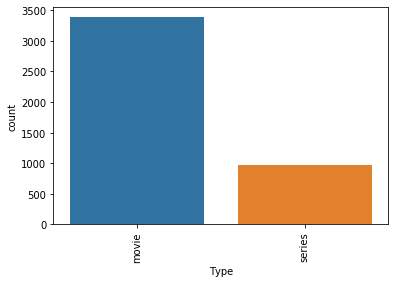

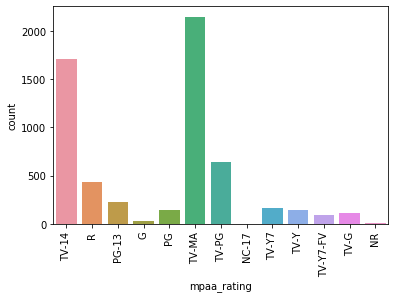

In [7]:
plot_cols = ['Type', 'mpaa_rating']
for plot_col in plot_cols:
    fig = sns.countplot(plot_col, data=movie)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    plt.show()

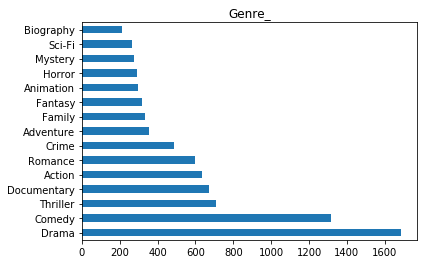

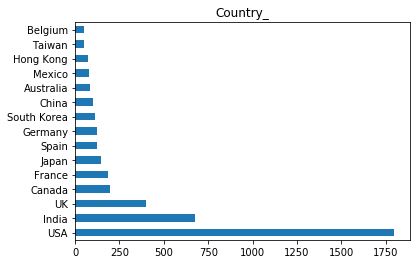

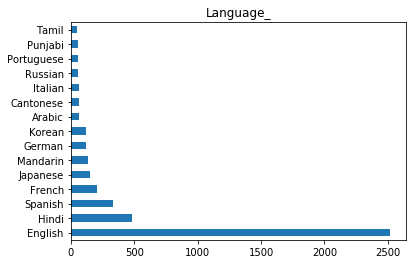

In [8]:
prefixes = ['Genre_', 'Country_', 'Language_']
for prefix in prefixes:
    barplot_dummies(movie_dummy, prefix)

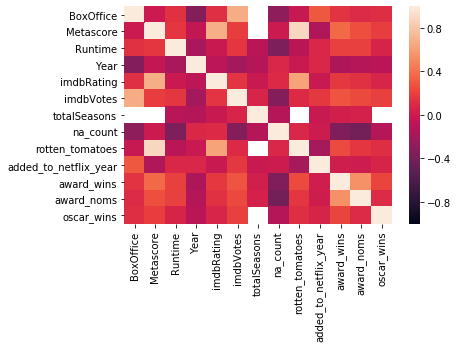

In [9]:
sns.heatmap(movie.corr(), vmin=-1, vmax=1)
plt.show()

In [17]:
movie_dummy

,Actors,Awards,BoxOffice,DVD,Director,Metascore,Plot,Poster,Production,Rated,...,Country_Turkey,Country_UK,Country_USA,Country_Uganda,Country_Ukraine,Country_United Arab Emirates,Country_Uruguay,Country_Vietnam,Country_West Germany,Country_Zimbabwe
0,"Waheeda Rehman, Abhishek Bachchan, Sonam Kapoo...",2 wins & 7 nominations.,862128.0,16 Jun 2009,Rakeysh Omprakash Mehra,45.0,"In the ancient walled city of Delhi, an Americ...",https://m.media-amazon.com/images/M/MV5BMTMyMT...,UTV Communications,Not Rated,...,0,0,0,0,0,0,0,0,0,0
1,"Johnny Depp, Aaron Eckhart, Michael Rispoli, A...",2 wins & 4 nominations.,13000000.0,14 Feb 2012,Bruce Robinson,56.0,American journalist Paul Kemp takes on a freel...,https://m.media-amazon.com/images/M/MV5BMTM5OD...,The Film District,R,...,0,1,1,0,0,0,0,0,0,0
2,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",Won 4 Oscars. Another 152 wins & 209 nominations.,292568851.0,07 Dec 2010,Christopher Nolan,74.0,A thief who steals corporate secrets through t...,https://m.media-amazon.com/images/M/MV5BMjAxMz...,Warner Bros. Pictures,PG-13,...,0,1,1,0,0,0,0,0,0,0
3,"Megan Cavanagh, Mark DeCarlo, Debi Derryberry,...",Nominated for 1 Oscar. Another 5 nominations.,80865848.0,02 Jul 2002,John A. Davis,65.0,An eight year-old boy genius and his friends m...,https://m.media-amazon.com/images/M/MV5BMzczYz...,Paramount Pictures,G,...,0,0,1,0,0,0,0,0,0,0
4,"Jeremy Irvine, Peter Mullan, Emily Watson, Nie...",Nominated for 6 Oscars. Another 15 wins & 71 n...,79883359.0,03 Apr 2012,Steven Spielberg,72.0,Young Albert enlists to serve in World War I a...,https://m.media-amazon.com/images/M/MV5BMjExNz...,Walt Disney Pictures,PG-13,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://m.media-amazon.com/images/M/MV5BZGU5ND...,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4305,NaN,NaN,NaN,NaN,NaN,NaN,This docuseries disputes the Mexican governmen...,https://m.media-amazon.com/images/M/MV5BZjJhZD...,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4311,NaN,NaN,NaN,NaN,NaN,NaN,The Philippine jail known for a viral Michael ...,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4312,NaN,NaN,NaN,NaN,NaN,NaN,Anomalies in the Earth's atmosphere cause irre...,https://m.media-amazon.com/images/M/MV5BNzAxOT...,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [72]:
movie_dummy = movie_dummy.sort_values('added_to_netflix')

movie_dummy['added_netflix_month'] = movie_dummy['added_to_netflix'].dt.to_period('M')
movie_dummy['added_netflix_month'] = movie_dummy['added_netflix_month'].dt.to_timestamp()

# movie_dummy['added_netflix_month'] = movie_dummy['added_to_netflix'].dt.month

In [73]:
genre_cols = [c for c in movie_dummy if c.startswith('Genre_')]

genre = movie_dummy[['added_netflix_month'] + genre_cols]
genre_by_month = genre.groupby(['added_netflix_month']).sum()
genre_by_month = genre_by_month.reset_index()

genre_by_month = pd.melt(genre_by_month, 
                         id_vars=['added_netflix_month'],
                         var_name='genre',
                         value_name='count')
genre_by_month['genre'] = genre_by_month['genre'].str.replace('Genre_', '')

top_genres = genre_by_month.groupby('genre').sum().sort_values('count', ascending=False)
top_genres = top_genres.index[:5]

plot_df = genre_by_month[genre_by_month['genre'].isin(top_genres)]
plot_df = plot_df[plot_df['added_netflix_month'] >= '2016-01-01']

fig = px.line(plot_df,
              x='added_netflix_month', 
              y='count',
              color='genre',
              title='Movies Added to Netflix per Month')

fig.update_xaxes(title="Date")
fig.update_yaxes(title="Number Added to Netflix")
fig.for_each_trace(lambda t: t.update(name=t.name.replace('genre=', '')))

## Model Prep

In [12]:
drop_columns = ['Poster', 'flixable_url', 'Response', 
                'Awards', 'Rated', 'imdbID', 'DVD', 'Website',
                'BoxOffice', 'Released', 'added_to_netflix',
                'Writer', 'Actors', 'Plot',
                'rotten_tomatoes', 'Metascore', 'Production',
                'totalSeasons', 'Runtime', 'Director',
                'Title', 'Ratings']

movie = movie.drop(columns=drop_columns)

In [13]:
movie_dummy = str_get_dummies(movie, 
                              columns=list_cols, 
                              sep=', ', 
                              prefix=list_cols, 
                              drop_first=True)

movie_dummy = pd.get_dummies(movie_dummy,
                             columns=['Type', 'mpaa_rating'],
                             drop_first=True)

In [14]:
movie_dummy = movie_dummy.dropna()
movie_dummy.shape

(4061, 280)

In [15]:
y_col = 'imdbRating'
X = movie_dummy.drop(columns=[y_col])
y = movie_dummy[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [16]:
# n_trees = 200

# params = {'subsample': [0.5, 0.75, 1.0],
#           'colsample_bytree': [0.5, 0.75, 1.0],
#           'max_depth': [2, 3, 4]}

# xgb_cv = XGBRegressor(objective='reg:squarederror', 
#                       n_estimators=n_trees,
#                       earning_rate=2 / n_trees)
                                    
# xgb_cv = GridSearchCV(xgb_cv, params, cv=2, verbose=1)
# xgb_cv.fit(X_train, y_train)

# print(xgb_cv.best_params_)
# xgb = xgb_cv.best_estimator_

In [17]:
# Best params from last search
params = {'colsample_bytree': 0.75, 'max_depth': 4, 'subsample': 1.0}

xgb = XGBRegressor(objective='reg:squarederror', 
                   n_estimators=n_trees,
                   earning_rate=2 / n_trees,
                   **params)

xgb.fit(X_train, y_train)

NameError: name 'n_trees' is not defined

In [ ]:
train_score = xgb_cv.score(X_train, y_train)
test_score = xgb_cv.score(X_test, y_test)

print(f'Train score: {train_score:.2f}')
print(f'Test score: {test_score:.2f}')

In [ ]:
y_pred = xgb_cv.predict(X_test)

min_pred = min(y_pred)
max_pred = max(y_pred)
x = [min_pred, max_pred]
y = [min_pred, max_pred]

plt.scatter(y_pred, y_test)
plt.plot(x, y)
plt.xlabel('Fitted')
plt.ylabel('Actual')
plt.xlim((min_pred, max_pred))
plt.ylim((min_pred, max_pred))
plt.show()

mae = (y_test - y_pred).abs().mean()
mape = ((y_test - y_pred) / y_test).abs().mean()

print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape * 100:.2f}%')